**Importing libraries**

In [43]:
# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#optuna and LGBM library 
import optuna
import sklearn.datasets
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Split train_data
import sklearn.model_selection
from sklearn.model_selection import train_test_split

##from google.colab import files
import warnings
warnings.filterwarnings('ignore')

import preprocessing module
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_validate

In [ ]:
pip install optuna
pip install lightgbm

**Load the dataset**

In [72]:
# Load files into a pandas dataframe
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')
variables = pd.read_csv('VariableDefinitions.csv')

# Let’s observe the shape of our datasets.
print('train data shape :', train.shape)
print('test data shape :', test.shape)

# inspect train data
train.head()

train data shape : (23524, 13)
test data shape : (10086, 12)


,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [73]:
# Check for missing values
print('missing values:', train.isnull().sum())

missing values: country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64


In [97]:
# Convert target label to numerical Data
le = LabelEncoder()
train['bank_account'] = le.fit_transform(train['bank_account'])

#Separate training features from target
x_train = train.drop(['bank_account'], axis=1)
y_train = train['bank_account']

print(y_train)

0        1
1        0
2        1
3        0
4        0
        ..
23519    0
23520    0
23521    0
23522    0
23523    0
Name: bank_account, Length: 23524, dtype: int32


In [215]:
# function to preprocess our data from train models
def preprocessing_data(data):

    # Convert the following numerical labels from interger to float
    #float_array = data[["household_size", "age_of_respondent", "year"]].values.astype(float)
    
    # categorical features to be onverted to One Hot Encoding
    categ = ["relationship_with_head",
             "marital_status",
             "education_level",
             "job_type",
             "country",
             "location_type",
             "cellphone_access",
             "gender_of_respondent"]
    
    # One Hot Encoding conversion
    data = pd.get_dummies(data, prefix_sep="_", columns=categ)
    
    # Label Encoder conversion
   # data["location_type"] = le.fit_transform(data["location_type"])
   # data["cellphone_access"] = le.fit_transform(data["cellphone_access"])
   # data["gender_of_respondent"] = le.fit_transform(data["gender_of_respondent"])
    
    # drop uniquid column
    data = data.drop(["uniqueid"], axis=1)
    
    # scale our data into range of 0 and 1
    #scaler = MinMaxScaler(feature_range=(0, 1))
    #data = scaler.fit_transform(data)
    
    return data                  

In [282]:
def objective(trial):
    iris = sklearn.datasets.load_iris()
    x, y = iris.data, iris.target

    random_state = trial.suggest_categorical("random_state", [0, 25, 100, None])
    learning_rate = trial.suggest_float("learning_rate",0.001,0.1, step = 0.0001)
    n_estimators = trial.suggest_int("n_estimators", 600,700)    
    max_depth = trial.suggest_int("max_depth", 5,30)    
    num_leaves = trial.suggest_int("num_leaves", 2,131072)        
    max_bin = trial.suggest_int("max_bin", 160,300, step = 10)         
    bagging_fraction = trial.suggest_float("bagging_fraction",0.1,1.0, step=0.1)
    feature_fraction  = trial.suggest_float("feature_fraction ",0.1,1.0, step=0.1)    
    lambda_l1  = trial.suggest_float("lambda_l1 ",0.0,10, step=0.01)
    lambda_l2  = trial.suggest_float("lambda_l2 ",0.0,10, step=0.01)       
    
    clf = LGBMClassifier(
        objective="binary",
        random_state=random_state,        
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        num_leaves=num_leaves,
        max_bin=max_bin,        
        lambda_l1=lambda_l1, #same as reg_alpha and lambda
        lambda_l2=lambda_l2,
        bagging_fraction =bagging_fraction,
        feature_fraction =feature_fraction
        #colsample_bytree=colsample_bytree, #same as feature_fraction        
        #min_samples_leaf=min_samples_leaf,        
        #min_child_samples=min_child_samples,        
        #reg_alpha=reg_alpha,
        #reg_lambda=reg_lambda,
        #subsample=subsample, #same as bagging_fraction        
        )      
       
    f1_weigth_score = cross_val_score(clf, processed_train, y_train, n_jobs=-1, cv=10, scoring = 'f1_weighted')
    return f1_weigth_score.mean()

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials=100)

[I 2023-07-11 14:02:25,119] A new study created in memory with name: no-name-788c8f44-ab08-4f0e-af05-9412b9fd71ea
[I 2023-07-11 14:02:56,678] Trial 0 finished with value: 0.8628034145799468 and parameters: {'random_state': 100, 'learning_rate': 0.046900000000000004, 'n_estimators': 649, 'max_depth': 15, 'num_leaves': 45300, 'max_bin': 170, 'bagging_fraction': 0.5, 'feature_fraction ': 0.30000000000000004, 'lambda_l1 ': 5.01, 'lambda_l2 ': 1.7}. Best is trial 0 with value: 0.8628034145799468.
[I 2023-07-11 14:03:47,053] Trial 1 finished with value: 0.8626620811304562 and parameters: {'random_state': None, 'learning_rate': 0.0345, 'n_estimators': 680, 'max_depth': 21, 'num_leaves': 49400, 'max_bin': 160, 'bagging_fraction': 0.9, 'feature_fraction ': 0.4, 'lambda_l1 ': 5.22, 'lambda_l2 ': 4.36}. Best is trial 0 with value: 0.8628034145799468.
[I 2023-07-11 14:04:19,855] Trial 2 finished with value: 0.8617556706477808 and parameters: {'random_state': 25, 'learning_rate': 0.0171, 'n_estimat

[I 2023-07-11 14:13:09,905] Trial 22 finished with value: 0.8615764080029109 and parameters: {'random_state': 0, 'learning_rate': 0.0883, 'n_estimators': 628, 'max_depth': 9, 'num_leaves': 38900, 'max_bin': 190, 'bagging_fraction': 0.1, 'feature_fraction ': 0.7000000000000001, 'lambda_l1 ': 5.95, 'lambda_l2 ': 9.28}. Best is trial 15 with value: 0.8633010888607797.
[I 2023-07-11 14:13:15,131] Trial 23 finished with value: 0.8626817053518548 and parameters: {'random_state': 0, 'learning_rate': 0.0723, 'n_estimators': 610, 'max_depth': 12, 'num_leaves': 55700, 'max_bin': 160, 'bagging_fraction': 0.4, 'feature_fraction ': 0.5, 'lambda_l1 ': 4.25, 'lambda_l2 ': 7.79}. Best is trial 15 with value: 0.8633010888607797.
[I 2023-07-11 14:13:53,144] Trial 24 finished with value: 0.8607434618777257 and parameters: {'random_state': 0, 'learning_rate': 0.0548, 'n_estimators': 640, 'max_depth': 17, 'num_leaves': 49800, 'max_bin': 210, 'bagging_fraction': 0.6, 'feature_fraction ': 1.0, 'lambda_l1 ': 

[I 2023-07-11 14:26:49,697] Trial 45 finished with value: 0.8618463587167081 and parameters: {'random_state': None, 'learning_rate': 0.043000000000000003, 'n_estimators': 606, 'max_depth': 18, 'num_leaves': 62300, 'max_bin': 180, 'bagging_fraction': 0.4, 'feature_fraction ': 0.6, 'lambda_l1 ': 5.53, 'lambda_l2 ': 8.02}. Best is trial 15 with value: 0.8633010888607797.
[I 2023-07-11 14:27:21,440] Trial 46 finished with value: 0.8613780705594511 and parameters: {'random_state': 25, 'learning_rate': 0.055600000000000004, 'n_estimators': 628, 'max_depth': 14, 'num_leaves': 69500, 'max_bin': 290, 'bagging_fraction': 0.5, 'feature_fraction ': 0.9, 'lambda_l1 ': 2.97, 'lambda_l2 ': 9.77}. Best is trial 15 with value: 0.8633010888607797.
[I 2023-07-11 14:27:25,726] Trial 47 finished with value: 0.8620921589071363 and parameters: {'random_state': 100, 'learning_rate': 0.0599, 'n_estimators': 638, 'max_depth': 6, 'num_leaves': 18500, 'max_bin': 200, 'bagging_fraction': 0.1, 'feature_fraction ': 

[I 2023-07-11 14:31:30,921] Trial 68 finished with value: 0.8594591827077682 and parameters: {'random_state': 0, 'learning_rate': 0.0751, 'n_estimators': 626, 'max_depth': 13, 'num_leaves': 44800, 'max_bin': 200, 'bagging_fraction': 0.1, 'feature_fraction ': 0.6, 'lambda_l1 ': 0.76, 'lambda_l2 ': 8.42}. Best is trial 15 with value: 0.8633010888607797.
[I 2023-07-11 14:31:36,300] Trial 69 finished with value: 0.861982412765798 and parameters: {'random_state': 0, 'learning_rate': 0.0665, 'n_estimators': 614, 'max_depth': 11, 'num_leaves': 42600, 'max_bin': 190, 'bagging_fraction': 0.6, 'feature_fraction ': 0.7000000000000001, 'lambda_l1 ': 3.58, 'lambda_l2 ': 9.26}. Best is trial 15 with value: 0.8633010888607797.
[I 2023-07-11 14:31:41,097] Trial 70 finished with value: 0.8629346064904364 and parameters: {'random_state': 0, 'learning_rate': 0.09190000000000001, 'n_estimators': 677, 'max_depth': 7, 'num_leaves': 47400, 'max_bin': 180, 'bagging_fraction': 0.5, 'feature_fraction ': 0.5, 'l

[I 2023-07-11 14:35:32,210] Trial 91 finished with value: 0.8633981435108508 and parameters: {'random_state': 0, 'learning_rate': 0.044000000000000004, 'n_estimators': 604, 'max_depth': 9, 'num_leaves': 47700, 'max_bin': 180, 'bagging_fraction': 1.0, 'feature_fraction ': 0.30000000000000004, 'lambda_l1 ': 4.3, 'lambda_l2 ': 6.13}. Best is trial 87 with value: 0.8634045498526653.
[I 2023-07-11 14:35:36,473] Trial 92 finished with value: 0.863429694704909 and parameters: {'random_state': 0, 'learning_rate': 0.049, 'n_estimators': 604, 'max_depth': 8, 'num_leaves': 47300, 'max_bin': 180, 'bagging_fraction': 1.0, 'feature_fraction ': 0.30000000000000004, 'lambda_l1 ': 5.32, 'lambda_l2 ': 6.25}. Best is trial 92 with value: 0.863429694704909.
[I 2023-07-11 14:35:41,155] Trial 93 finished with value: 0.8623307286629798 and parameters: {'random_state': 0, 'learning_rate': 0.044000000000000004, 'n_estimators': 605, 'max_depth': 8, 'num_leaves': 49400, 'max_bin': 180, 'bagging_fraction': 1.0, '

In [283]:
trial = study.best_trial
print('Metrics: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trials.params))

Metrics: 0.863429694704909
Best hyperparameters: {'random_state': 25, 'learning_rate': 0.022000000000000002, 'n_estimators': 419, 'max_depth': 19}


In [304]:
optuna.visualization.plot_optimization_history(study)

In [286]:
optuna.visualization.plot_slice(study)

In [287]:
# Split train_data
from sklearn.model_selection import train_test_split

X_Train, X_Val, y_Train, y_val = train_test_split(processed_train, y_train, stratify = y_train,
                                                  test_size = 0.1, random_state=0)

In [300]:
from sklearn.ensemble import BaggingClassifier
# calculate accuracy
from sklearn import metrics

# Define the base model with best hyperparameters
final_model = LGBMClassifier(
    seed=0,
    objective="binary",
    random_state=0,
    learning_rate='0.0164',
    max_depth=14,
    #min_child_samples=100, #24
    n_estimators=670,
    num_leaves=43507,
    lambda_l1=8.08,
    lambda_l2=7.13,
    max_bin=260,
    bagging_fraction=0.1,
    feature_fraction=0.7000000000000001
)

# Create a bagging ensemble of LGBMClassifier
bagging_model = BaggingClassifier(
    base_estimator=final_model,
    n_estimators=10,
    random_state=0,
    n_jobs=-1
)

# Fit the ensemble model on the whole dataset
#ensemble_model.fit(processed_train, y_train)
bagging_model.fit(processed_train, y_train)

# Predictions
#y_pred = ensemble_model.predict(X_Val)
y_pred = bagging_model.predict(X_Val)

# Calculate Mean Absolute Error
mae = np.mean(np.abs(y_val - y_pred))
print("Mean Absolute Error:", mae)
mse = np.mean((y_val - y_pred))
print("Mean Squared Error:", mse)
print('Predicted Class: %d' % y_pred[0])

from sklearn.metrics import confusion_matrix

# Confusion matrix
print(metrics.confusion_matrix(y_val, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_val, bagging_model.predict(X_Val)))

Mean Absolute Error: 0.09817254568635785
Mean Squared Error: 0.06672333191670209
Predicted Class: 0
[[1985   37]
 [ 194  137]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      2022
           1       0.79      0.41      0.54       331

    accuracy                           0.90      2353
   macro avg       0.85      0.70      0.74      2353
weighted avg       0.89      0.90      0.89      2353



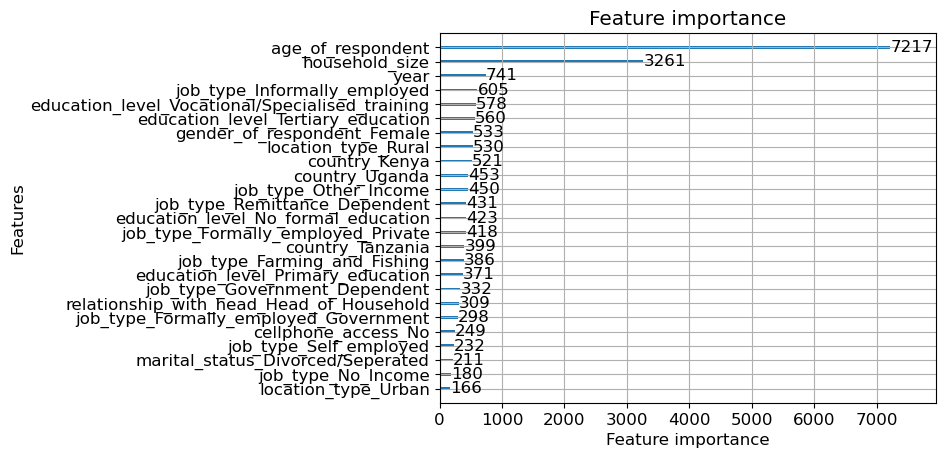

In [301]:
#Display only the top 10 important features based on the model's feature importance
import lightgbm as lgb
import matplotlib.pyplot as plt

final_model.fit(processed_train, y_train)
lgb.plot_importance(final_model, max_num_features=25)

plt.show()

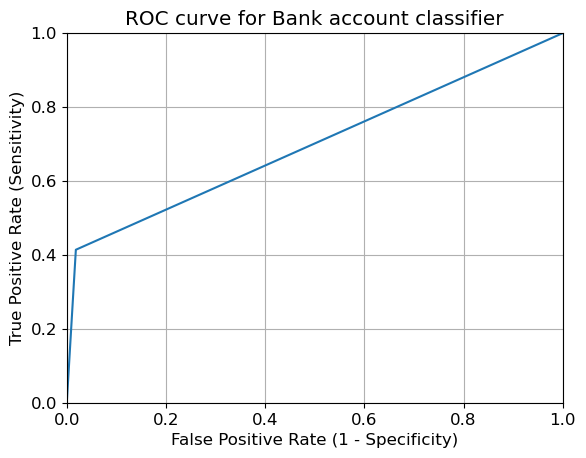

In [302]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Bank account classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [204]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [205]:
evaluate_threshold(0.5)

Sensitivity: 0.4471299093655589
Specificity: 0.9821958456973294


In [206]:
evaluate_threshold(0.3)

Sensitivity: 0.4471299093655589
Specificity: 0.9821958456973294


In [207]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
print(metrics.roc_auc_score(y_val, y_pred))

0.7146628775314442


In [208]:
# calculate cross-validated AUC
from sklearn.cross_validation import cross_val_score
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

ModuleNotFoundError: No module named 'sklearn.cross_validation'

In [293]:
test.bank_account = bagging_model.predict(processed_test)

# Create submission DataFrame
submission = pd.DataFrame({"uniqueid": test["uniqueid"] + " x " + test["country"],
                           "bank_account": test.bank_account})

In [294]:
#show the five sample
submission.sample(5)
submission.to_csv('first_submission.csv', index=False)

,uniqueid,bank_account
5971,uniqueid_12106 x Rwanda,0
9728,uniqueid_2645 x Uganda,0
6069,uniqueid_12204 x Rwanda,1
2258,uniqueid_8327 x Kenya,0
6627,uniqueid_6902 x Tanzania,0


Save results in the CSV file.